In [ ]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
from nilearn import image as nimg
from nilearn import plotting as nplot
import bids
from nltools.file_reader import onsets_to_dm
from nltools.stats import regress, zscore
from nltools.data import Brain_Data, Design_Matrix
from nltools.stats import find_spikes 
from nilearn.plotting import view_img, glass_brain, plot_stat_map
from bids import BIDSLayout, BIDSValidator
import os
from pathlib import Path
from nilearn.glm.first_level import make_first_level_design_matrix
from nilearn.plotting import plot_design_matrix
from nilearn.glm.first_level import FirstLevelModel
from nilearn import plotting
from nilearn.plotting import plot_contrast_matrix
from nilearn.glm.first_level import FirstLevelModel
from nilearn import plotting
# creating mean img for plotting purposes 
from nilearn.image import mean_img
from nilearn.image import load_img
from nibabel import load
from nibabel.gifti import GiftiDataArray, GiftiImage
from nilearn.glm.first_level import run_glm as run_glm
from nilearn.glm import compute_contrast
import nilearn
fsaverage = nilearn.datasets.fetch_surf_fsaverage(mesh='fsaverage5')


In [ ]:
layout = bids.BIDSLayout('/gscratch/fang/NARSAD/MRI/derivatives/fmriprep', validate=False,
                  config=['bids','derivatives'])

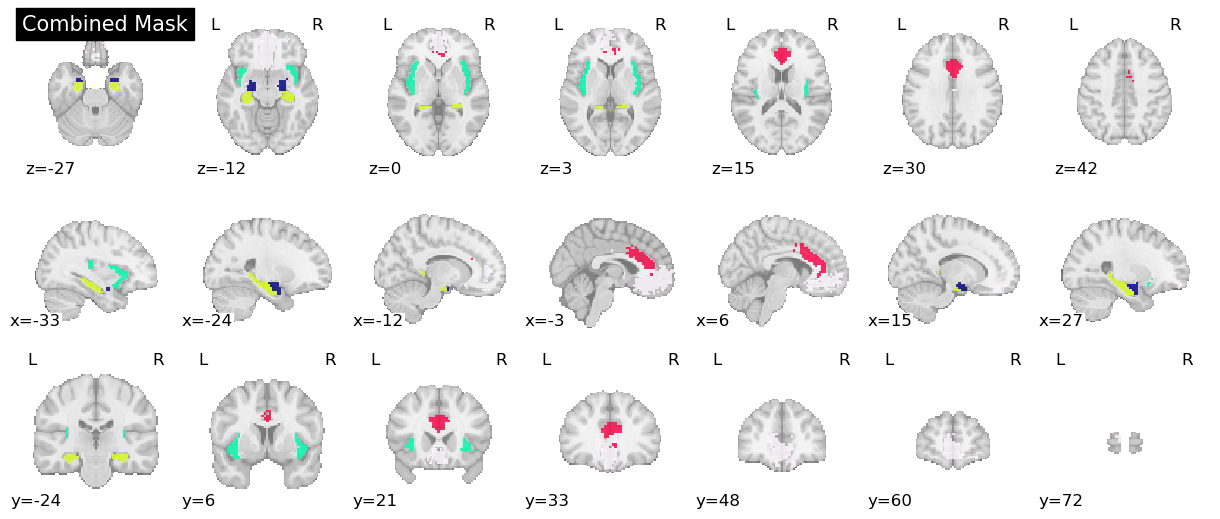

In [ ]:
# run to load in previously-derived masks + create combined masker object (for ease of first-level computation)
from nilearn.maskers import NiftiLabelsMasker
from nibabel import Nifti1Image
from nilearn import plotting, masking

path = '/gscratch/fang/NARSAD/ROI/anatomically-constrained'
os.chdir(path)

#making space defining image
sub = 'N234'
fmri_imgs = layout.get(subject=sub,
                        datatype='func',
                        desc='preproc',
                        space='MNI152NLin2009cAsym',
                        extension='nii.gz',
                       return_type='file')
space_defining_image = masking.compute_brain_mask(fmri_imgs[0])

amygdala = nib.load('amygdala.nii')
hippocampus = nib.load('hippocampus.nii')
insula = nib.load('insula.nii')
acc = nib.load('acc.nii')
vmpfc = nib.load('vmpfc.nii')

amygdala_data = amygdala.get_fdata() * 1
insula_data = insula.get_fdata() * 2
hippocampus_data = hippocampus.get_fdata() * 3
vmpfc_data = vmpfc.get_fdata() * 5
acc_data = acc.get_fdata() * 4

# Combine the masks by taking the maximum value at each voxel
combined_mask_data = np.maximum.reduce([
    amygdala_data,
    insula_data,
    hippocampus_data,
    acc_data,
    vmpfc_data
])

combined_mask_img = Nifti1Image(combined_mask_data, affine=insula.affine)
plotting.plot_roi(combined_mask_img, display_mode='mosaic',draw_cross=False, alpha=0.8, title="Combined Mask")

# First, initialize masker 
masker = NiftiLabelsMasker(
    combined_mask_img, mask_img=space_defining_image
)

## whole phase

### first level

In [49]:
# removing subjects w wrong sequence / missing phases: 
subjects = layout.get_subjects()
subjects1 = subjects
del(subjects1[0]) #sub101 has 2mm seq for phase 2, 3mm (correct) for phase 3
del(subjects1[49]) # sub201, has 2mm seq for phase 2, 3mm (correct) for phase 3 

subjects = layout.get_subjects()
subjects2 = subjects
del(subjects2[15]) #sub 120 missing phase 3

subjects = layout.get_subjects()

In [ ]:
# can load in onsets (events.tsv) for all subs here as all subs have same task timings 
onsets_phase2 = pd.read_excel('//gscratch/fang/NARSAD/MRI/source_data/behav/task-Narsad_events.xlsx',sheet_name=0)
onsets_phase3 = pd.read_excel('/gscratch/fang/NARSAD/MRI/source_data/behav/task-Narsad_events.xlsx',sheet_name=1)
onsets_phase3_sub202 = pd.read_excel('/gscratch/fang/NARSAD/MRI/source_data/behav/task-Narsad_events.xlsx',sheet_name=2)

onsets = onsets_phase2, onsets_phase3
onsets_sub202 = onsets_phase2, onsets_phase3_sub202

def load_bids_events(layout,onsets, subject, task, phaseno):
    '''Create a design_matrix instance from BIDS event file'''
    
    tr = layout.get_tr()
    # change lines below -- can change to "mask", change task to "self-other"
    func_files = layout.get(subject=subject,
                        datatype='func', task=task,
                        desc='preproc',
                        space='MNI152NLin2009cAsym',
                        extension='nii.gz',
                       return_type='file')
    func_file = nimg.load_img(func_files)
    n_tr = func_file.shape[-1]
    onsets=onsets[phaseno]
    #onsets = pd.read_csv(layout_raw.get(subject=subject, suffix='events')[run].path, sep='\t') -- line to use if events changes by 
    
    # line below is isolating the onset, duration, and trial type columns -- change according to events.tsv format 
    onsets_actual = onsets.iloc[:, [0,1,3]]
    onsets_actual.columns = ['onset', 'duration','trial_type'] # make sure this order matches with what's loaded in as onsets 
    sampling_freq = 1/tr
    n_scans=n_tr
    return onsets_actual, tr, n_scans

In [ ]:
# to iterate through subjects ... 
#for sub in subjects 
from scipy.stats import norm

p001_unc = norm.isf(0.001)

file_lists_phase2 = {
        "CSR-CSS": list(),   
        "CSR-CS-": list(),
        "CSS-CS-": list(),
        "CSR-fix": list(), 
        "CSS-fix": list(),   
        "CSminus-fix": list()
        }

file_lists_phase3 = {
        "CSR-CSS": list(),   
        "CSR-CS-": list(),
        "CSS-CS-": list(),
        "CSR-fix": list(), 
        "CSS-fix": list(),   
        "CSminus-fix": list()
        }

sub_order_phase2 = {
        "CSR-CSS": list(),   
        "CSR-CS-": list(),
        "CSS-CS-": list(),
        "CSR-fix": list(), 
        "CSS-fix": list(),   
        "CSminus-fix": list()
        }

sub_order_phase3 = {
        "CSR-CSS": list(),   
        "CSR-CS-": list(),
        "CSS-CS-": list(),
        "CSR-fix": list(), 
        "CSS-fix": list(),   
        "CSminus-fix": list()
        }

tasks = ['phase2','phase3']

for phaseno, task in enumerate(tasks): 

    if task == 'phase2':
        subject_list = subjects1 
    elif task == 'phase3':
        subject_list = subjects2        
    
    for sub in subject_list: 

        fmri_imgs = layout.get(subject=sub,
                        datatype='func', task=task,
                        desc='preproc',
                        space='MNI152NLin2009cAsym',
                        extension='nii.gz',
                       return_type='file')
        hrf_model = "spm" #canonical hrf 
        high_pass = 0.01 # The cutoff for the drift model is 0.01 Hz.

        dmn_time_series = []
        for con_img in fmri_imgs:
            dmn_time_series.append(masker.fit_transform(con_img))
        dmn_time_series = np.concatenate(dmn_time_series, axis = 0)
        
        confound_files = layout.get(subject=sub,
                            datatype='func', task=task,
                            desc='confounds',
                           extension="tsv",
                           return_type='file')
        # Select confounds 
        confound_vars = ['trans_x','trans_x_derivative1','trans_x_derivative1_power2','trans_x_power2',
                           'trans_y','trans_y_derivative1','trans_y_derivative1_power2','trans_y_power2',
                             'trans_z','trans_z_derivative1','trans_z_derivative1_power2','trans_z_power2',
                             'rot_x','rot_x_derivative1','rot_x_derivative1_power2','rot_x_power2',
                             'rot_y','rot_y_derivative1','rot_y_derivative1_power2','rot_y_power2',
                             'rot_z','rot_z_derivative1','rot_z_derivative1_power2','rot_z_power2',
                             'csf','csf_derivative1','csf_derivative1_power2','csf_power2',
                             'white_matter','white_matter_derivative1','white_matter_derivative1_power2','white_matter_power2'
                        ]

        final_confounds = confound_vars

        design_matrices = []

        print("Creating First Level Design matrix ... ")

        if sub == 'N202':
            onsets_file = onsets_sub202 
        else:
            onsets_file = onsets
        
        for img in enumerate(fmri_imgs):
    # Build experimental paradigm
            events,tr,n_scans = load_bids_events(layout,onsets_file, sub, task, phaseno)
        # Define the sampling times for the design matrix
            frame_times = np.arange(n_scans) * tr
            confound_file = confound_files[0]
            confound_df = pd.read_csv(confound_file, delimiter='\t')
            confound_df = confound_df[final_confounds]
            confound_df.fillna(0, inplace=True)            
        # Build design matrix with the previously defined parameters
            design_matrix = make_first_level_design_matrix(
                frame_times,
                events,
                hrf_model=hrf_model,
                drift_model="polynomial",
                drift_order=3,
                add_regs=confound_df,
                add_reg_names=confound_vars,
                high_pass=high_pass,
            )

        design_matrices.append(design_matrix)
        design_matrix_allruns = []    
        design_matrix_allruns = np.concatenate(design_matrices, axis = 0)
            
        contrast_matrix = []
        contrast_matrix = np.eye(design_matrix.shape[1])
        basic_contrasts = {
            column: contrast_matrix[i]
            for i, column in enumerate(design_matrix.columns)
        }
        
        contrasts = {
            "CSR-CSS": (basic_contrasts["CSR"] - basic_contrasts["CSS"]),   
            "CSR-CS-": (basic_contrasts["CSR"] - basic_contrasts["CS-"]),   
            "CSS-CS-": (basic_contrasts["CSS"] - basic_contrasts["CS-"]),
            "CSR-fix": (basic_contrasts["CSR"] - basic_contrasts["FIXATION"]), 
            "CSS-fix": (basic_contrasts["CSS"] - basic_contrasts["FIXATION"]),
            "CSminus-fix": (basic_contrasts["CS-"] - basic_contrasts["FIXATION"])
        }

    #fmri_glm = FirstLevelModel()
        labels, estimates = run_glm(dmn_time_series, design_matrix_allruns)

        for contrast_id, contrast_val in contrasts.items():
            contrast = compute_contrast(labels, estimates, contrast_val)
            z_score = contrast.z_score()
            print(f"{contrast_id}: Z-score outputs: {z_score}")

            # Ensure subject data is appended properly
            if phaseno == 0:  # phase2
                file_lists_phase2[contrast_id].append(contrast)
                sub_order_phase2[contrast_id].append(f'sub{sub}-ses{task}')            
            else:  # phase3
                file_lists_phase3[contrast_id].append(contrast)
                sub_order_phase3[contrast_id].append(f'sub{sub}-ses{task}')

        print(f"Subject {sub} completed for {task}!")

    

In [ ]:
# to export / save data 

import pandas as pd
import numpy as np

# Define regions of interest
regions_of_interest = [
    'Amygdala', 'Insula', 'Hippocampus', 'ACC', 
    'VMPFC'
]

# Create an Excel writer object
output_dir = "/gscratch/scrubbed/fanglab/xiaoqian/NARSAD/ROI/Gillian/first_level"
os.makedirs(output_dir, exist_ok=True)  # Create directory if it doesn't exist

output_path = os.path.join(output_dir, "phase2_data-new.xlsx")

with pd.ExcelWriter(output_path) as writer:
    for contrast in file_lists_phase2.keys():  # Loop through each contrast
        contrast_list = file_lists_phase2[contrast]  # List of contrast objects (one per subject)

        # Dictionary to store z-scores for each region
        data_dict = {region: [] for region in regions_of_interest}

        # Loop through each subject's contrast object
        for subject_contrast in contrast_list:
            z_scores = subject_contrast.z_score()  # Extract z-scores
            
            # Append z-scores to the corresponding region
            for region_no, region in enumerate(regions_of_interest):
                data_dict[region].append(z_scores[region_no])  # Store each subject's z-score

        # Convert to a DataFrame (rows = subjects, columns = regions)
        df = pd.DataFrame(data_dict)

        # Save to a new sheet in the Excel file
        df.to_excel(writer, sheet_name=contrast, index=False)


output_path = os.path.join(output_dir, "phase3_data-new.xlsx")

with pd.ExcelWriter(output_path) as writer:
    for contrast in file_lists_phase3.keys():  # Loop through each contrast
        contrast_list = file_lists_phase3[contrast]  # List of contrast objects (one per subject)

        # Dictionary to store z-scores for each region
        data_dict = {region: [] for region in regions_of_interest}

        # Loop through each subject's contrast object
        for subject_contrast in contrast_list:
            z_scores = subject_contrast.z_score()  # Extract z-scores
            
            # Append z-scores to the corresponding region
            for region_no, region in enumerate(regions_of_interest):
                data_dict[region].append(z_scores[region_no])  # Store each subject's z-score

        # Convert to a DataFrame (rows = subjects, columns = regions)
        df = pd.DataFrame(data_dict)

        # Save to a new sheet in the Excel file
        df.to_excel(writer, sheet_name=contrast, index=False)

print("Excel file with z-scores saved successfully!")


Excel file with z-scores saved successfully!
